# Анализ процесса проведения и результатов A/B-тестирования

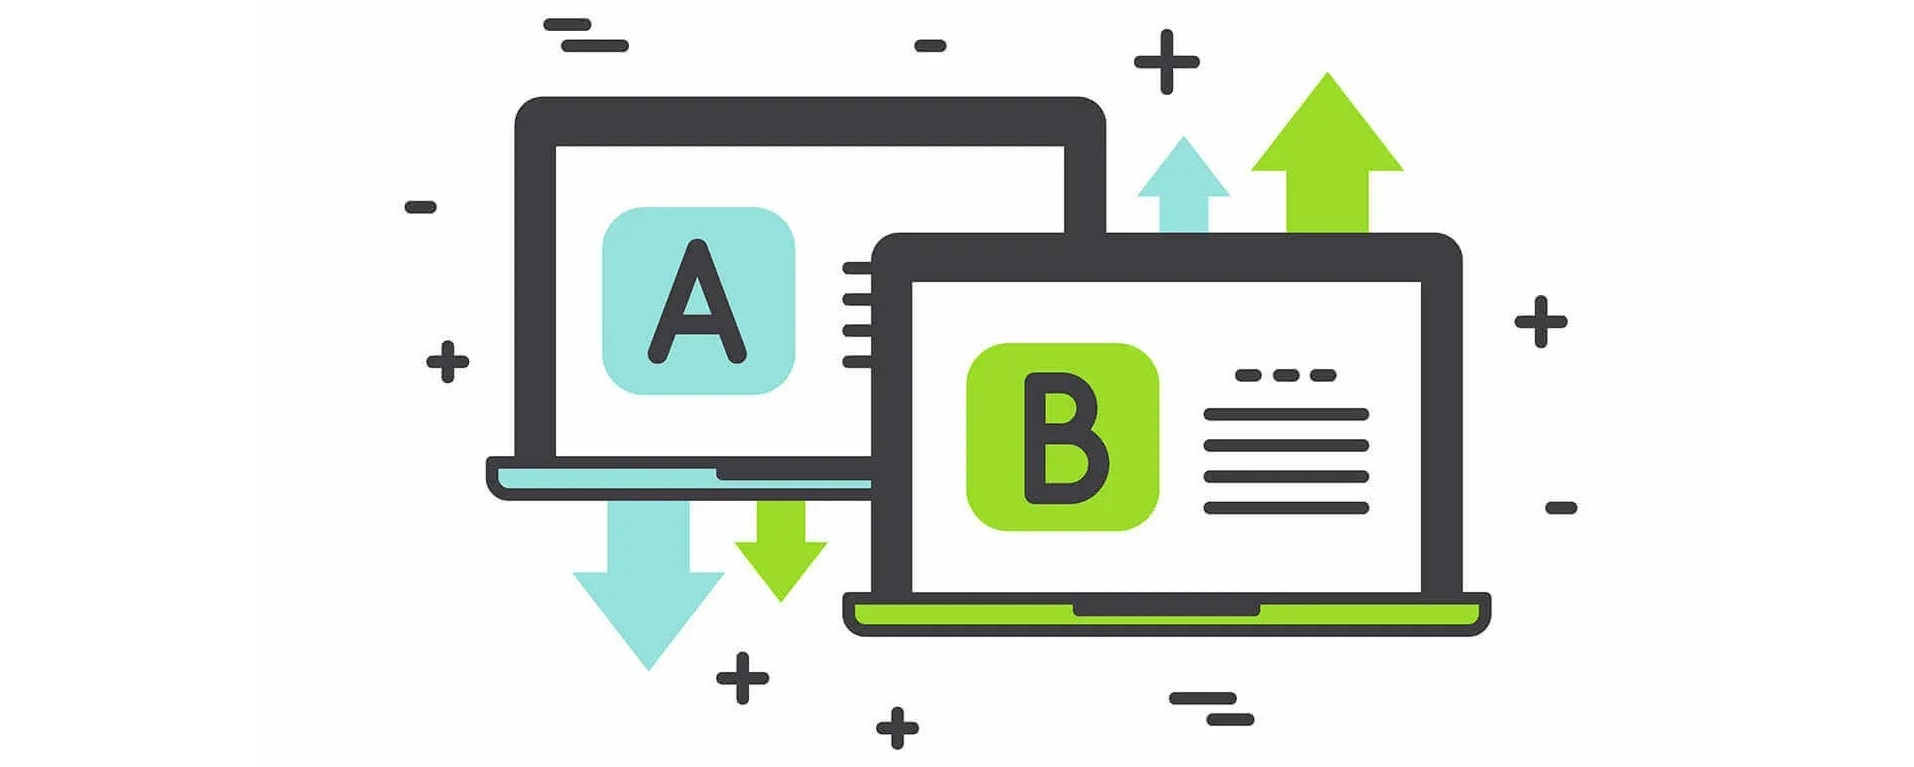

**Содержание**

* [Описание проекта](#description)
* [Шаг 1. Загрузка и общий анализ данных](#step_1)
* [Шаг 2. Анализ корректности проведения теста](#step_2)
    * [Распределение пользователей по признакам](#step_2_1)
    * [Время проведения теста](#step_2_2)
    * [Аудитория теста](#step_2_3)
    * [Вывод по шагу 2](#step_2_4)
* [Шаг 3. Исследовательский анализ данных](#step_3)
    * [Распределение событий в выборках по дням](#step_3_1)
    * [Распределение событий в выборках по группам](#step_3_2)
    * [Распределение событий на пользователя](#step_3_3)
    * [Анализ конверсии в группах](#step_3_4)
    * [Вывод по шагу 3](#step_3_5)
* [Шаг 4. Статистический анализ](#step_4)
* [Выводы и рекомендации](#final)
    * [Рекомендации](#final_1)
    * [Выводы](#final_2)

## Описание проекта <a class='anchor' id='description'></a>

**Цель проекта** — провести оценку результатов A/B-теста. В нашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.
Задачи проекта:
- оценить корректность проведения теста;
- проанализировать результаты теста.

Чтобы оценить корректность проведения теста, необходимо проверить:

- пересечение тестовой аудитории с конкурирующим тестом;
- совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

### Техническое задание

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

### Описание данных

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

## Шаг 1. Загрузка и общий анализ данных <a class='anchor' id='step_1'></a>

Загрузим необходимые для анализа библиотеки и дополнительные функции.

In [68]:
import pandas as pd
import numpy as np
import datetime as dt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats as st
import math as mth

In [69]:
# функция для подсчета дубликатов и получения общих сведений о датасете
def get_info(data):
    display(data.head())
    print()
    print('Число дубликатов:', data.duplicated().sum())
    print()
    data.info()

In [70]:
# функция для подсчета доли пропусков
def get_na(data):
    na_info = (
        pd.DataFrame(data.isna().mean())
        .rename(columns={0: 'NaN'})
        .style
        .set_caption('Доля пропусков')
        .background_gradient('coolwarm')
        .format('{:.2%}')
        )
    return na_info

Загрузим и осмотрим датасеты проекта.

В датафрейм `marketing_events` запишем календарь маркетинговых кампаний.

In [71]:
marketing_events = pd.read_csv('ab_project_marketing_events.csv')

In [72]:
get_info(marketing_events)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11



Число дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


В датасете не обнаружено явных дубликатов. Все столбцы имеют строковый формат.

In [73]:
get_na(marketing_events)

,NaN
name,0.00%
regions,0.00%
start_dt,0.00%
finish_dt,0.00%


Пропуски в датасете не обнаружены.

Приведем к формату `datetime` столбцы `start_dt` и `finish_dt`.

In [74]:
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])

В датафрейм `events` запишем действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

In [75]:
events = pd.read_csv('final_ab_events.csv')

In [76]:
get_info(events)

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99



Число дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


В датасете не обнаружено явных дубликатов. 3 из 4-х столбцов имеют строковый формат, столбец `details` имеет формат дробных чисел с плавающей точкой.

In [77]:
get_na(events)

,NaN
user_id,0.00%
event_dt,0.00%
event_name,0.00%
details,85.75%


Подавляющая часть столбца `details` содержит пропуски. Этот столбец хранит сведения о сумме покупке (если она произошла). Оставим пропуски как есть, это не скажется на дальнейшем анализе. 

Приведем столбец `event_dt` к формату `datetime`.

In [78]:
events['event_dt'] = pd.to_datetime(events['event_dt'])

В датафрейм `new_users` запишем данные о пользователях, зарегистрировавшихся с 7 по 21 декабря 2020 года.

In [79]:
new_users = pd.read_csv('final_ab_new_users.csv')

In [80]:
get_info(new_users)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone



Число дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


В датасете не обнаружено явных дубликатов. Все столбцы имеют строковый формат.

In [81]:
get_na(new_users)

,NaN
user_id,0.00%
first_date,0.00%
region,0.00%
device,0.00%


Пропуски в датасете не обнаружены.

Приведем столбец `first_date` к формату `datetime`.

In [82]:
new_users['first_date'] = pd.to_datetime(new_users['first_date'])

В датафрейм `participants` запишем данные об участниках A/B-тестов.

In [83]:
participants = pd.read_csv('final_ab_participants.csv')

In [84]:
get_info(participants)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test



Число дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


В датасете не обнаружено явных дубликатов. Все столбцы имеют строковый формат.

In [85]:
get_na(participants)

,NaN
user_id,0.00%
group,0.00%
ab_test,0.00%


Пропуски в датасете не обнаружены.

Узнаем, какое количество пользователей участвует в тестировании в разбивке по названию теста, региону и типу устройства.

In [86]:
(participants
 .merge(new_users, on='user_id', how='left')
 .groupby(['ab_test', 'region', 'device'])
 .agg({'user_id':'nunique'})
 .rename(columns={'user_id':'total_users'})
 .style
 .background_gradient(high=0.1)
)

Самыми крупными группами для тестов являются пользователи `Android`, `PC` и `iPhone` из региона EU. Также, подавляющая доля тестируемой аудитории находится в регионе EU.

Узнаем, какое количество A/B-тестов проходит в различных регионах и в разбивке по типам устройств.

In [87]:
(participants
 .merge(new_users, on='user_id', how='left')
 .groupby(['region', 'device'])
 .agg({'ab_test':'nunique'})
 .rename(columns={'ab_test':'total_ab_tests'})
 .style
 .background_gradient(high=1))

Два одновременных A/B-теста идут только в регионе `EU`. Оба тестирования затрагивают все виды устройств пользователей.

## Шаг 2. Анализ корректности проведения теста <a class='anchor' id='step_2'></a>

### Распределение пользователей по признакам <a class='anchor' id='step_2_1'></a>

Посмотрим на распределение новых пользователей по регионам, а также сколько пользователей принимало участие в различных A/B-тестированиях.

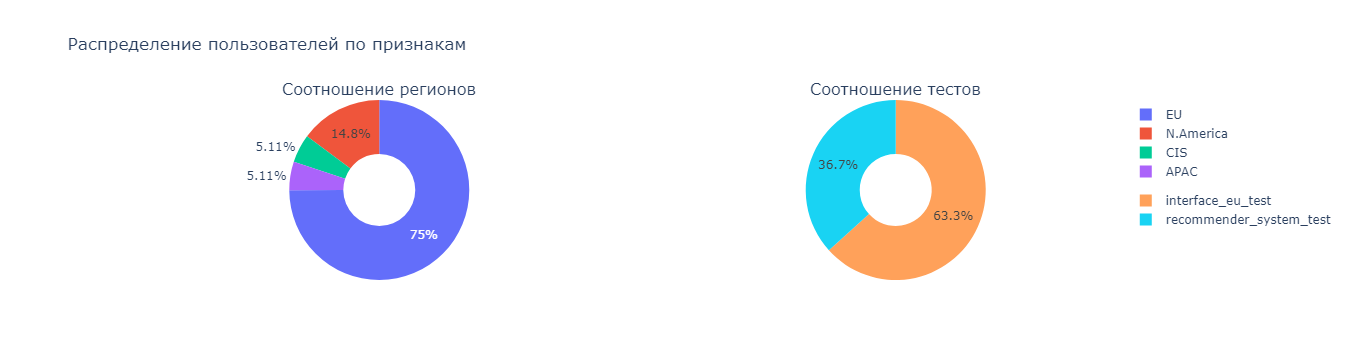

In [88]:
regions = pd.DataFrame(new_users['region'].value_counts(normalize=True).reset_index())
ab_tests = pd.DataFrame(participants['ab_test'].value_counts(normalize=True).reset_index())

fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]], 
                    subplot_titles=['Соотношение регионов', 'Соотношение тестов'])
fig.add_trace(go.Pie(labels=regions['index'], values=regions['region'], legendgroup='1'),
              1, 1)
fig.add_trace(go.Pie(labels=ab_tests['index'], values=ab_tests['ab_test'], legendgroup='2'),
              1, 2)

fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Распределение пользователей по признакам", width=900)

fig.show()

Согласно техническому заданию, аудиторией главного теста является регион `EU`. Данному региону принадлежат 75% пользователей. Остальные регионы не интересуют нас в нашем исследовании, поэтому позже исключим их.

36.7% пользователей являются участниками `recommender_system_test`. 63.3% пользователей участвуют в `interface_eu_test`. После проверки на пересечение выборок, также исключим лишние данные о конкурирующем тесте. Если обнаружатся пользователи, которые участвуют в обоих тестах, необходимо исключить их. Влияние измененого интерфейса и дизайна может привести к нетипичному поведению пользователей в группах и исказить результаты главного тестирования.

Оставим только пользователей из региона EU.

In [89]:
new_users = new_users[new_users['region'] == 'EU']

### Время проведения теста <a class='anchor' id='step_2_2'></a>

Рассмотрим все маркетинговые мероприятия, проводимые в течение 2020 года.

In [90]:
marketing_events.sort_values(by='start_dt')

,name,regions,start_dt,finish_dt
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
4,4th of July Promo,N.America,2020-07-04,2020-07-11
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07


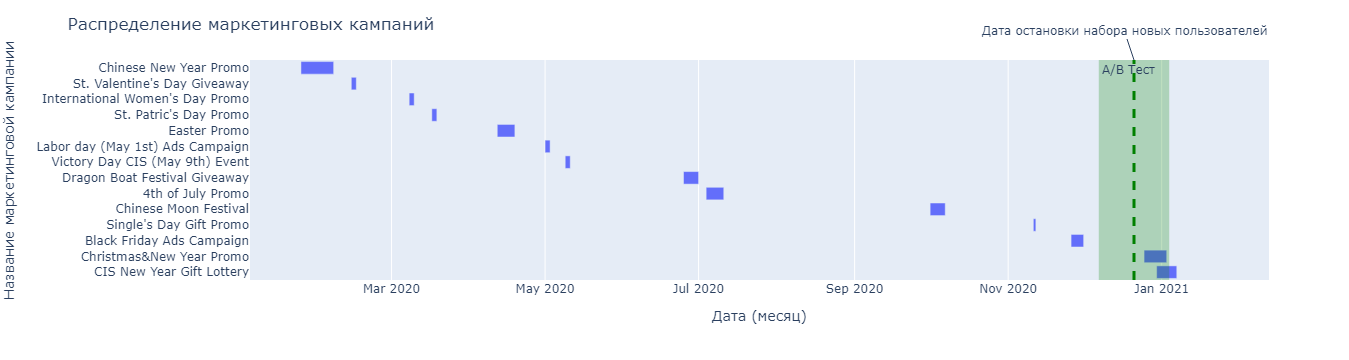

In [91]:
fig = px.timeline(marketing_events.sort_values(by='start_dt'), x_start="start_dt", x_end="finish_dt", y="name")
fig.update_yaxes(autorange="reversed")
fig.add_vrect(x0="2020-12-07", x1="2021-01-04", 
              annotation_text="A/B Тест", annotation_position="top left",
              fillcolor="green", opacity=0.25, line_width=0)
fig.add_vline(x="2020-12-21", line_width=3, line_dash="dash", line_color="green")
fig.add_annotation(x="2020-12-21", y=1, yref="paper", text="Дата остановки набора новых пользователей")
fig.update_layout(
    title='Распределение маркетинговых кампаний',
    xaxis_title='Дата (месяц)',
    yaxis_title='Название маркетинговой кампании')
fig.show()

На графике прозрачно-зеленой областью обозначен период проведения главного A/B-тестирования, пунктирной линией обозначена дата остановки набора новых пользователей. Как мы видим, 2 маркетинговые кампании выпадают на период теста, что является существенным нарушением при проведении теста. Маркетинговая кампания приводит к нетипичному поведению пользователей, привлекая их повышенный интерес.

Конкретно региона `EU` касается только кампания Christmas & New Year Promo. Тем не менее, это негативно влияет на корректность тестирования и искажает результаты. 	

Также, весомым фактором является выбор самого времени проведения теста. Новогодние праздники сильно меняют поведение пользователей, в связи с чем время проведения выбрано некорректно. 

### Аудитория теста <a class='anchor' id='step_2_3'></a>

Посмотрим, как группы распределены в главном и конкурирующем тестировании.

In [92]:
participants.groupby(['ab_test', 'group']).nunique()

user_id
ab_test                 group         
interface_eu_test       A         5831
                        B         5736
recommender_system_test A         3824
                        B         2877

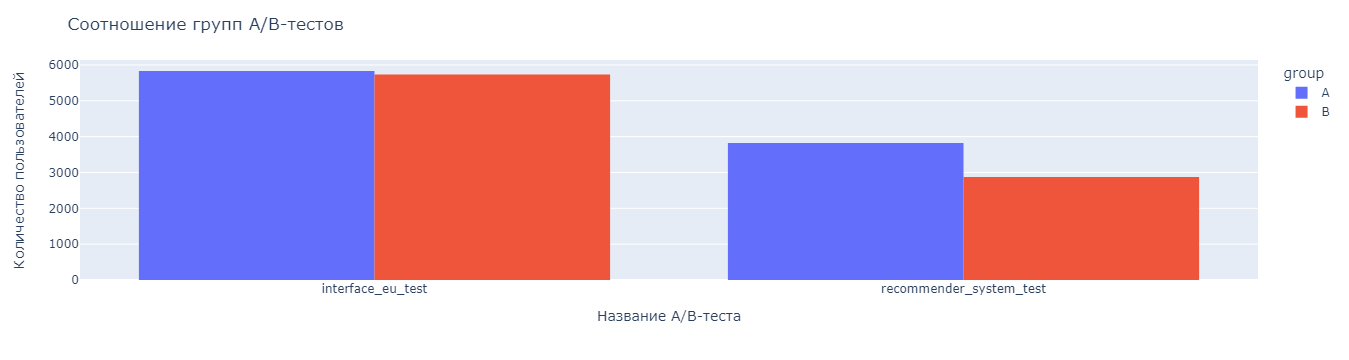

In [93]:
fig = px.histogram(participants.groupby(['ab_test', 'group']).nunique().reset_index(), 
                   x="ab_test", y="user_id", 
                   color='group', barmode='group',
                   width=600)
fig.update_layout(
    title='Соотношение групп A/B-тестов',
    xaxis_title='Название A/B-теста',
    yaxis_title='Количество пользователей')
fig.show()

Мы видим, что группы A и B главного теста `recommender_system_test` сильно несбалансированы. По численности пользователей группа А превышает группу B на четверть (около 25%). Это является существенным нарушением и говорит о некорректности разбиения на группы в тесте.

Проверим, есть ли пересечения между контрольной и тестовой группой главного теста.

In [94]:
users_group_A = participants.query("ab_test == 'recommender_system_test' & group == 'A'")
users_group_B = participants.query("ab_test == 'recommender_system_test' & group == 'B'")
print('Пересечений пользователей между группой A и B:', len(users_group_A.merge(users_group_B, how='inner', on='user_id')))

Пересечений пользователей между группой A и B: 0


Смешивания групп A и B в главном тесте не выявлено. 

In [95]:
test_1 = participants.query("ab_test == 'recommender_system_test'")
test_2 = participants.query("ab_test == 'interface_eu_test'")
print('Пересечений пользователей между главным тестом и конкурирующим:', 
      test_1.merge(test_2, how='inner', on='user_id')['user_id'].nunique())

Пересечений пользователей между главным тестом и конкурирующим: 1602


Обнаружено пересечение с конкурирующим тестом в размере 1 602 пользователя. Поскольку тест является конкурирующим - смешивание пользователей негативно сказывается на результатах обоих тестов.

Оставим в датасете `participants` только участников главного теста `recommender_system_test`.

In [96]:
participants = participants.query("ab_test == 'recommender_system_test'")
print('Число участников теста:', len(participants))

Число участников теста: 6701


Исключим тех пользователей, которые попали в оба тестирования - таких пользователей 1 602.

In [97]:
participants = participants[~(participants.isin(test_1.merge(test_2, how='inner', on='user_id')['user_id'].unique()))].dropna()
print('Число участников теста:', len(participants))

Число участников теста: 5099


Таким образом, в датафрейме `participants` у нас остались только уникальные пользователи из региона `EU`, участвующие только в тесте `recommender_system_test` - на данном этапе их число 5 099.

In [98]:
participants

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
5,4FF2998A348C484F,A,recommender_system_test
6,7473E0943673C09E,A,recommender_system_test
...,...,...,...
6696,053FB26D6D49EDDC,A,recommender_system_test
6697,9D263B8EF15CF188,B,recommender_system_test
6698,F2FBBA33F37DEC46,A,recommender_system_test
6699,29C92313A98B1176,B,recommender_system_test


Посмотрим, в течение какого времени происходило привлечение новых пользователей в регионе EU. Согласно техническому заданию, их набор должен был остановиться 21 декабря.

Найдем пересечение новых пользователей `new_users` и участников теста `participants`.

In [99]:
eu_new_users = (new_users[new_users['region'] == 'EU']
                .merge(participants, on='user_id', how='inner')
                .groupby('first_date')
                .agg({'user_id':'nunique'})
                .reset_index()
                .rename(columns={'user_id':'unique_users'}))
eu_new_users['cumsum'] = eu_new_users['unique_users'].cumsum()
print('Кол-во участников теста из новых пользователей:', eu_new_users['unique_users'].sum(), 'из 6000')
print('Доля от необходимого числа по ТЗ:', '{0:.2%}'.format(eu_new_users['unique_users'].sum() / 6000))

Кол-во участников теста из новых пользователей: 4749 из 6000
Доля от необходимого числа по ТЗ: 79.15%


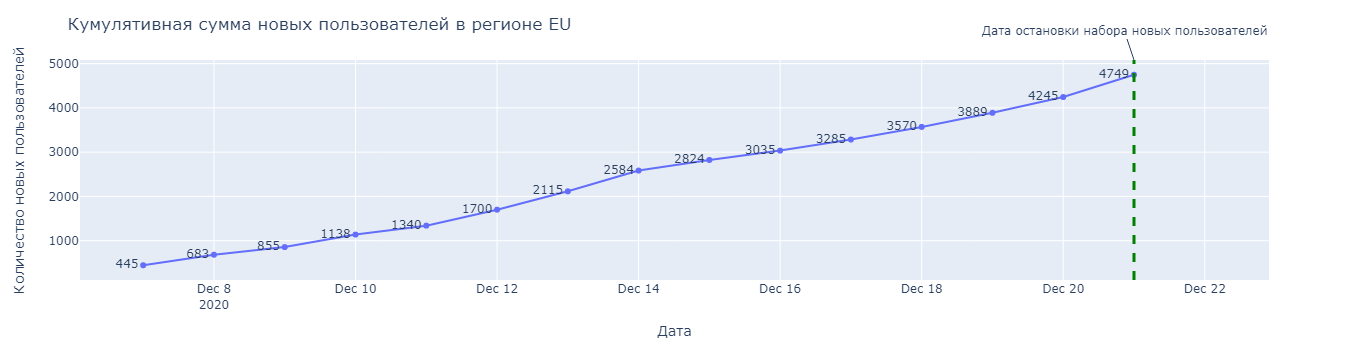

In [100]:
fig = px.line(eu_new_users, x="first_date", y='cumsum', markers=True, text="cumsum")
fig.update_traces(textposition="middle left")
fig.add_vline(x="2020-12-21", line_width=3, line_dash="dash", line_color="green")
fig.add_annotation(x="2020-12-21", y=1, yref="paper", text="Дата остановки набора новых пользователей")
fig.update_layout(
    title='Кумулятивная сумма новых пользователей в регионе EU',
    xaxis_title='Дата',
    yaxis_title='Количество новых пользователей')
fig.show()

In [101]:
print('Реальное кол-во участников теста из новых пользователей:', eu_new_users['unique_users'].sum(), 'из 6000')
print('Доля от необходимого числа по ТЗ:', '{0:.2%}'.format(eu_new_users['unique_users'].sum() / 6000))
print('Всего участников теста:', len(participants))
print('Всего новых пользователей:', len(new_users))
print('Всего новых пользователей из региона EU до 21 декабря:', 
      len(new_users[(new_users['region'] == 'EU') & 
                    (new_users['first_date'] <= '2020-12-21')]))

Реальное кол-во участников теста из новых пользователей: 4749 из 6000
Доля от необходимого числа по ТЗ: 79.15%
Всего участников теста: 5099
Всего новых пользователей: 46270
Всего новых пользователей из региона EU до 21 декабря: 42340


Набор новых пользователей из `EU` остановился 21 декабря, но не совпадает с ТЗ заказчика - по состоянию на 4 января требование выполнено лишь на 79%, набрано 4 749 чел. из 6 000. Датафрейм `participants` насчитывает 5 099 чел., но только 4 749 из них являются новыми пользователями.

В датафрейме `new_users` найдем новых пользователей из региона `EU`, которые зарегистрировались после 21 декабря.

In [102]:
print('Новые пользователи после 21 декабря:', 
      len(new_users[(new_users['region'] == 'EU') & (new_users['first_date'] > '2020-12-21')]))

Новые пользователи после 21 декабря: 3930


Узнаем, есть ли в датафрейме `participants` пересечения с данными пользователями, которые зарегистрировались после 21 декабря.

In [103]:
print('Пользователи главного теста с регистрацией после 21 декабря:', 
      len(participants
          .merge(new_users[(new_users['region'] == 'EU') & 
                           (new_users['first_date'] > '2020-12-21')], 
                 on='user_id', how='inner')))

Пользователи главного теста с регистрацией после 21 декабря: 0


Пересечений не наблюдается - в главном тесте участвуют пользователи, зарегистрировашиеся с 7 по 21 декабря.

Исключим из датафрейма `new_users` пользователей, которые зарегистрировались после 21 декабря.

In [104]:
new_users = new_users[(new_users['region'] == 'EU') & (new_users['first_date'] <= '2020-12-21')]
print('Всего уникальных пользователей:', new_users['user_id'].nunique())

Всего уникальных пользователей: 42340


Таким образом, у нас имеются данные о 42 340 пользователях, из которых 5 099 принимают участие в главном тестировании.

Посмотрим на соотношение групп на данном этапе.

In [105]:
participants.groupby(['ab_test', 'group']).nunique()

user_id
ab_test                 group         
recommender_system_test A         2903
                        B         2196

Не соблюдено ожидаемое количество участников теста - 6 000 чел. Также, наблюдается значимый дисбаланс групп - разница составляет 25%.

### Вывод по шагу 2 <a class='anchor' id='step_2_4'></a>

В процессе анализа корректности проведения теста были выявлены следующие факты:
- Согласно техническому заданию, аудиторией главного теста является регион `EU`. Данному региону принадлежат 75% пользователей. 
- В данных были отфильтрованы только пользователи из региона EU.
- 36.7% пользователей являются участниками `recommender_system_test`. 63.3% пользователей участвуют в `interface_eu_test`. 
- После проверки на пересечение выборок были исключены пользователи из конкурирующего теста на основании того, что влияние измененого интерфейса и дизайна может привести к нетипичному поведению пользователей в группах и исказить результаты главного тестирования.
- 2 маркетинговые кампании выпадают на период теста, что является существенным нарушением при проведении теста. Маркетинговая кампания приводит к нетипичному поведению пользователей, привлекая их повышенный интерес.

- Конкретно региона EU касается только кампания `Christmas & New Year Promo`. Тем не менее, это негативно влияет на корректность тестирования и искажает результаты.

- Весомым фактором является выбор самого времени проведения теста. Новогодние праздники сильно меняют поведение пользователей, в связи с чем время проведения выбрано некорректно.

- Группы A и B главного теста `recommender_system_test` сильно несбалансированы. По численности пользователей группа А превышает группу B на четверть (около 25%). Это является существенным нарушением и говорит о некорректности разбиения на группы в тесте.

- Смешивания групп A и B в главном тесте не выявлено.

- Обнаружено пересечение с конкурирующим тестом в размере 1 602 пользователя. Поскольку тест является конкурирующим - смешивание пользователей негативно сказывается на результатах обоих тестов.

- В датасете `participants` были оставлены только участники главного теста `recommender_system_test`. Были исключены пользователи, попавшие в оба тестирования - таких пользователей 1 602.

- В датасете `participants` остались только уникальные пользователи из региона `EU`, участвующие только в тесте `recommender_system_test` - на данном этапе их число 5 099.

- Выявлено, что в главном тесте участвуют пользователи, зарегистрировашиеся с 7 по 21 декабря.

- Из датафрейма `new_users` были исключены пользователи, которые зарегистрировались после 21 декабря.

- Были получены данные о 42 340 пользователях, из которых 5 099 принимают участие в главном тестировании. 

- Наблюдается дисбаланс групп - разница составляет 25%.

- Набор новых пользователей из EU остановился 21 декабря, но не совпадает с ТЗ заказчика - по состоянию на 4 января требование выполнено лишь на 79%, набрано 4 749 чел. из 6 000. Датафрейм `participants` насчитывает 5 099 чел., но только 4 749 из них являются новыми пользователями.

## Шаг 3. Исследовательский анализ данных <a class='anchor' id='step_3'></a>

Рассмотрим датафрейм `events`, в котором собраны события всех пользователей в исследуемом периоде.

In [106]:
print('Всего пользователей в events:', events['user_id'].nunique())
print('Всего событий в events:', len(events))
print('Дата первых событий:', events['event_dt'].min())
print('Дата последних событий:', events['event_dt'].max())

Всего пользователей в events: 58703
Всего событий в events: 440317
Дата первых событий: 2020-12-07 00:00:33
Дата последних событий: 2020-12-30 23:36:33


Объединим датафреймы `events` и `participants` таким образом, чтобы оставить только данные о событиях участников теста, число которых 5 099. Полученную сводную таблицу запишем в датафрейм `data`.

In [107]:
data = events.merge(participants[participants['ab_test'] == 'recommender_system_test'], on='user_id', how='right')

In [108]:
data

,user_id,event_dt,event_name,details,group,ab_test
0,D1ABA3E2887B6A73,2020-12-07 14:43:27,purchase,99.99,A,recommender_system_test
1,D1ABA3E2887B6A73,2020-12-25 00:04:56,purchase,4.99,A,recommender_system_test
2,D1ABA3E2887B6A73,2020-12-07 14:43:29,product_cart,NaN,A,recommender_system_test
3,D1ABA3E2887B6A73,2020-12-25 00:04:57,product_cart,NaN,A,recommender_system_test
4,D1ABA3E2887B6A73,2020-12-07 14:43:27,product_page,NaN,A,recommender_system_test
...,...,...,...,...,...,...
21110,6715343AFBA285AE,2020-12-07 10:12:15,login,NaN,B,recommender_system_test
21111,6715343AFBA285AE,2020-12-08 22:51:16,login,NaN,B,recommender_system_test
21112,6715343AFBA285AE,2020-12-09 02:28:03,login,NaN,B,recommender_system_test
21113,6715343AFBA285AE,2020-12-10 22:55:14,login,NaN,B,recommender_system_test


Мы получили данные о 21 115 событиях 5 099 участников теста в датафрейме `data`.

In [109]:
print('Уникальных пользователей:', data['user_id'].nunique())

Уникальных пользователей: 5099


### Распределение событий в выборках по дням <a class='anchor' id='step_3_1'></a>

Посмотрим на структуру тестирования во времени.

In [110]:
data['event_date'] = pd.to_datetime(data['event_dt']).dt.date

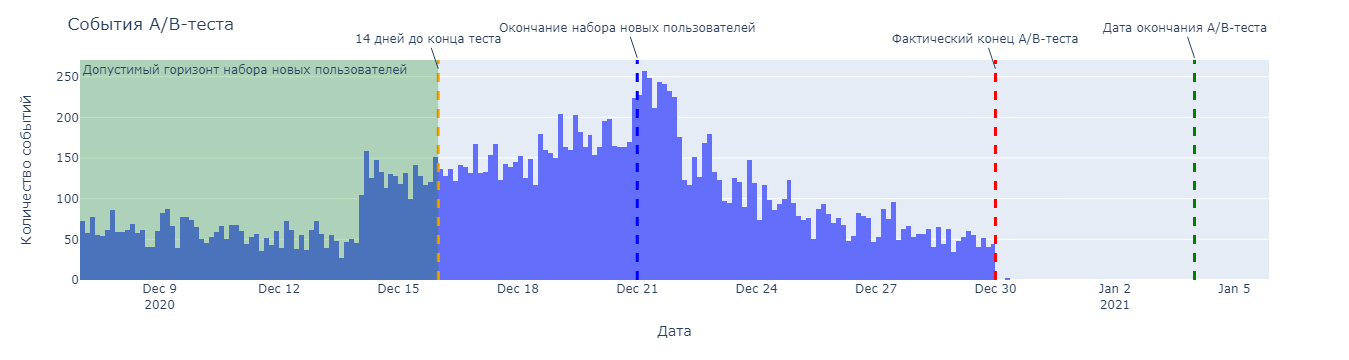

In [111]:
fig = px.histogram(data, x="event_dt", nbins=250)
fig.add_vline(x="2021-01-04", line_width=3, line_dash="dash", line_color="green")
fig.add_annotation(x="2021-01-04", y=1.01, yref="paper", text="Дата окончания A/B-теста")

fig.add_vline(x="2020-12-30", line_width=3, line_dash="dash", line_color="red")
fig.add_annotation(x="2020-12-30", y=0.96, yref="paper", text="Фактический конец A/B-теста")

fig.add_vline(x="2020-12-21", line_width=3, line_dash="dash", line_color="blue")
fig.add_annotation(x="2020-12-21", y=1.01, yref="paper", text="Окончание набора новых пользователей")

fig.add_vline(x="2020-12-16", line_width=3, line_dash="dash", line_color="orange")
fig.add_annotation(x="2020-12-16", y=0.96, yref="paper", text="14 дней до конца теста")

fig.add_vrect(x0="2020-12-07", x1="2020-12-16", 
              annotation_text="Допустимый горизонт набора новых пользователей", annotation_position="top left",
              fillcolor="green", opacity=0.25, line_width=0)

fig.update_layout(
    title='События A/B-теста',
    xaxis_title='Дата',
    yaxis_title='Количество событий')

fig.show()

Фактически, тестирование прервалось на 5 дней раньше запланированного срока - вместо 4 января мы видим резкий обрыв перед 30 декабря. Данные о событиях перестали собираться по неизвестным причинам. Возможно, из-за новогодних праздников тест перестал выполняться технически.

Поскольку дата окончания теста (4 января) сместилась влево на графике (красный пунктир), то соответственно сместился и горизонт теста в размере 14-ти дней. Изначально, этой точкой была дата окончания приема новых пользователей - 21 декабря (синий пунктир), но из-за смещения графика ближайшая граница сместилась в район 16 декабря (оранжевый пунктир).

Зеленой областью обозначено время, зарегистрировавшись в которое новые пользователи успеют провести не менее 14 дней активности. После оранжевого пунктира - это время составит уже менее 14 дней, а значит будет нарушаться требование технического задания.

На графике наблюдается несколько событий в районе 6 утра 30 декабря, которые больше похожи на шум.

In [112]:
data.sort_values(by='event_dt', ascending=False).head()

,user_id,event_dt,event_name,details,group,ab_test,event_date
3133,75845C83258FBF73,2020-12-30 06:42:52,product_cart,NaN,B,recommender_system_test,2020-12-30
3137,75845C83258FBF73,2020-12-30 06:42:52,login,NaN,B,recommender_system_test,2020-12-30
8034,BB3873E1AC6E7BC3,2020-12-29 23:38:29,product_page,NaN,A,recommender_system_test,2020-12-29
8038,BB3873E1AC6E7BC3,2020-12-29 23:38:28,login,NaN,A,recommender_system_test,2020-12-29
15332,817B7DE353CE7825,2020-12-29 23:38:10,product_page,NaN,A,recommender_system_test,2020-12-29


Удалим две строки с событиями от 30 декабря.

In [113]:
data = data[data['event_dt'] < '2020-12-30']

Теперь нам необходимо удалить пользователей, которые с момента регистрации успели провести менее 14 дней активности до окончания теста.

Для этого сначала расчитаем первое действие каждого пользователя, предварительно отсортировав датафрейм `data` по `event_dt` и `user_id`. Запишем результат в датафрейм `delta`.

In [114]:
delta = (data
         .sort_values(by=['event_dt', 'user_id'])
         .groupby('user_id')
         .agg({'event_dt':'first'})
         .reset_index()
         .rename(columns={'event_dt':'first_event'}))

In [115]:
delta

,user_id,first_event
0,0010A1C096941592,2020-12-17 21:07:27
1,003DF44D7589BBD4,2020-12-17 06:17:49
2,00505E15A9D81546,2020-12-14 17:28:32
3,005E096DBD379BCF,2020-12-21 07:20:39
4,006E3E4E232CE760,2020-12-17 16:40:41
...,...,...
2783,FF5A1CD38F5DD996,2020-12-21 19:32:01
2784,FF5B24BCE4387F86,2020-12-21 08:46:48
2785,FF825C1D791989B5,2020-12-19 19:29:18
2786,FF8CF7057415EB29,2020-12-21 16:09:41


В полученном датафрейме найдем разницу между датой первого действия пользователи и датой фактического окончания теста (29 декабря, 23:59). Запишем результат в столбец `timedelta`.

In [116]:
delta['timedelta'] = dt.datetime(2020, 12, 29, 23, 59) - delta['first_event']

Отфильтруем пользователей, у которых разница больше или равна 14 дням. Если разница менее 14 дней, значит не соблюдается необходимый горизонт теста и пользователь будет исключен из анализа.

In [117]:
delta[delta['timedelta'] >= np.timedelta64(14, 'D')]

,user_id,first_event,timedelta
2,00505E15A9D81546,2020-12-14 17:28:32,15 days 06:30:28
11,015CCC27BDB640E1,2020-12-09 12:43:12,20 days 11:15:48
14,016F758EB5C5A5DA,2020-12-13 17:06:55,16 days 06:52:05
15,0178FA423606B54B,2020-12-08 21:33:45,21 days 02:25:15
16,018019D84C070443,2020-12-15 12:24:22,14 days 11:34:38
...,...,...,...
2778,FF0CF3A2B430E000,2020-12-15 10:17:07,14 days 13:41:53
2779,FF120D67C4BE2DA3,2020-12-07 10:34:03,22 days 13:24:57
2780,FF1AB7A774128512,2020-12-14 23:59:54,14 days 23:59:06
2781,FF40F25452E70E3D,2020-12-07 11:42:36,22 days 12:16:24


Таким образом, мы сильно отфильтровали пользователей и оставили лишь 1 314 человек. Выполним слияние полученных пользователей с основным датафреймом `data`, в котором хранятся данные о всех событиях.

In [118]:
data = data.merge(delta[delta['timedelta'] >= np.timedelta64(14, 'D')], how='inner', on='user_id')

In [119]:
print('Уникальных пользователей:', data['user_id'].nunique())

Уникальных пользователей: 1314


Посмотрим, как распределены группы после преобразований.

In [120]:
data.groupby('group', as_index=False)['user_id'].nunique()

,group,user_id
0,A,907
1,B,407


Группа A превышает группу B в 2 раза - такой дисбаланс является грубым нарушением теста.

### Распределение событий в выборках по группам <a class='anchor' id='step_3_2'></a>

Посмотрим, как события распределены в разбивке по группам.

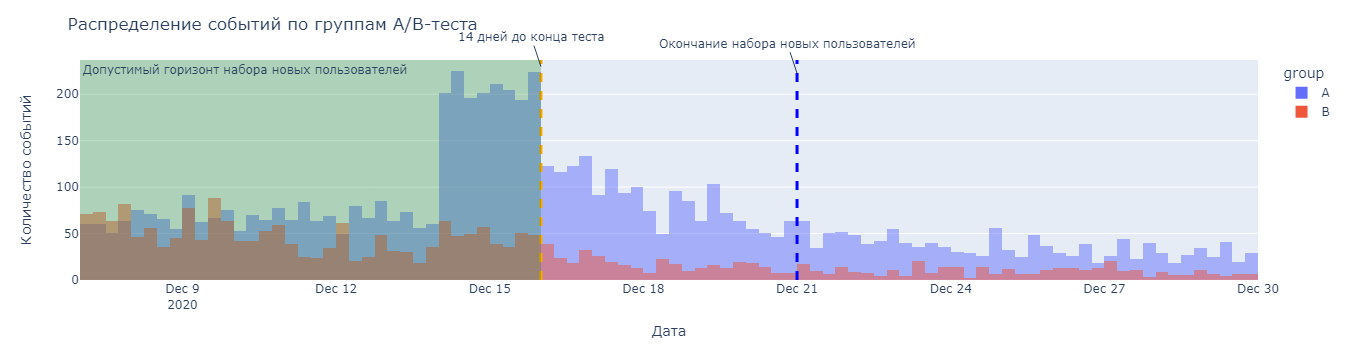

In [121]:
fig = px.histogram(data, x="event_dt", nbins=150, color='group', barmode='overlay')

fig.add_vline(x="2020-12-21", line_width=3, line_dash="dash", line_color="blue")
fig.add_annotation(x="2020-12-21", y=0.94, yref="paper", text="Окончание набора новых пользователей")

fig.add_vline(x="2020-12-16", line_width=3, line_dash="dash", line_color="orange")
fig.add_annotation(x="2020-12-16", y=0.97, yref="paper", text="14 дней до конца теста")

fig.add_vrect(x0="2020-12-07", x1="2020-12-16", 
              annotation_text="Допустимый горизонт набора новых пользователей", annotation_position="top left",
              fillcolor="green", opacity=0.25, line_width=0)

fig.update_layout(
    title='Распределение событий по группам A/B-теста',
    xaxis_title='Дата',
    yaxis_title='Количество событий')

fig.show()

Группа А (907 чел.) показывает большее количество событий в течение теста, чем группа B (407 чел.).

Наибольшая активность пользователей наблюдается в период с 14 по 16 декабря.

### Распределение событий на пользователя <a class='anchor' id='step_3_3'></a>

Расчитаем количество событий на одного пользователя в каждой из групп.

In [122]:
event_per_user = data.groupby(['group', 'user_id'], as_index=False).agg({'event_name':'count'})
event_per_user.groupby('group').agg({'event_name':['mean', 'median']})

event_name       
            mean median
group                  
A       7.217200      6
B       5.955774      5

В среднем у пользователя группы А происходит около 7 событий, медианное значение 6.
У пользователя группы B в среднем происходит меньше событий - около 6, медианное значение 5.

### Анализ конверсии в группах <a class='anchor' id='step_3_4'></a>

Посмотрим, сколько уникальных пользователей побывало на каждом этапе воронки.

In [123]:
data.groupby('event_name', as_index=False)['user_id'].nunique().sort_values(by='user_id', ascending=False)

,event_name,user_id
0,login,1314
2,product_page,808
1,product_cart,376
3,purchase,367


Количество на этапах корзины и покупки (`product_cart` и `purchase`) схожи в количестве пользователей, что может свидетельствовать об ошибке при сборе данных или логировании.

Сформируем воронки для групп A и B.

In [124]:
groups = (data
          .groupby(['group', 'event_name'], as_index=False)['user_id']
          .nunique()
          .sort_values(by=['group', 'user_id'], ascending=False))
groups

,group,event_name,user_id
4,B,login,407
6,B,product_page,221
7,B,purchase,108
5,B,product_cart,103
0,A,login,907
2,A,product_page,587
1,A,product_cart,273
3,A,purchase,259


В группе `B` количество покупок (108) превышает количество визитов в корзину (103) - нарушена последовательность этапов воронки. Скорее всего, в данных имеются пользователи, которые пропустили некоторые этапы воронки.

Посмотрим распределение первых действий пользователей.

In [125]:
first_action = data.sort_values(by='event_dt').groupby('user_id', as_index=False).agg({'event_name':'first'})

У 163 человек - первым действием сразу происходит покупка. Это говорит о том, что человек уже был зарегистрирован и залогирован ранее до начала теста - а значит, не является новым пользователем. В связи с тем, что это нарушает требование технического задания, исключим пользователей, у которых `login` не является первым действием.

Оставим в данных только тех пользователей, у которых первым действием является `login`.

In [126]:
first_action = first_action.query('event_name == "login"')
data = data.merge(first_action['user_id'], how='inner', on='user_id')
groups = (data
          .groupby(['group', 'event_name'], as_index=False)['user_id']
          .nunique()
          .sort_values(by=['group', 'user_id'], ascending=False)
          .rename(columns={'user_id':'users'}))
groups

,group,event_name,users
4,B,login,292
6,B,product_page,138
5,B,product_cart,62
7,B,purchase,45
0,A,login,637
2,A,product_page,367
1,A,product_cart,168
3,A,purchase,109


Отфильтровав пользователей без начального логирования, мы получили новые воронки для обоих групп. Построим график воронки.

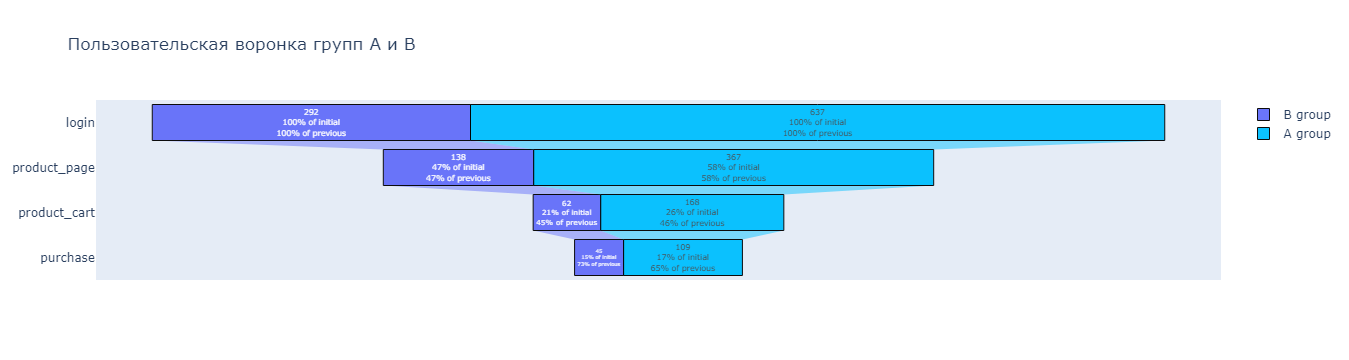

In [127]:
fig = go.Figure({"layout": {"title": {"text": "Пользовательская воронка групп A и B"}}})
funnel_a = groups.loc[groups['group'] == 'A']
funnel_b = groups.loc[groups['group'] == 'B']

fig = fig.add_trace(go.Funnel(
                name = 'B group',
                orientation = "h",
                textposition = "inside",
                y = funnel_b['event_name'],
                x = funnel_b['users'],
                opacity = 0.95,
                textinfo = "value+percent previous+percent initial",
                marker = {
                "line": {"width": 1, "color": "black"}}))

fig = fig.add_trace(go.Funnel(
                name = 'A group',
                orientation = "h",
                textposition = "inside",
                y = funnel_a['event_name'],
                x = funnel_a['users'],
                textinfo = "value+percent previous+percent initial",
                opacity = 0.95,
                marker = {"color": "deepskyblue",
                "line": {"width": 1, "color": "black"}}))

fig.show()

Как говорилось ранее, мы наблюдаем существенный дисбаланс размера групп - группа А превосходит группу B более чем в 2 раза - как изначально, так и на каждом этапе воронки. Принимать результаты тестирования не рекомендуется. Тестирование было выполнено со множеством грубых нарушений, в связи с чем интерпретация полученных результатов в определенной мере теряет смысл. Большинство требований технического задания было удовлетворено лишь частично.

Группа B является тестовой и демонстрирует более худшие показатели на каждом этапе воронки по сравнению с контрольной группой.

Группа А демонстрирует конверсию в покупку на уровне 17%, группа B - на уровне 15%.

### Вывод по шагу 3 <a class='anchor' id='step_3_5'></a>

По итогам исследовательского анализа данных можно утверждать следующее:
- В датафрейме `data` были агрегированы данные о 21 115 событиях 5 099 участников теста.
- Фактически, тестирование прервалось на 5 дней раньше запланированного срока - вместо 4 января конец зафиксирован 29 декабря. Данные о событиях перестали собираться по неизвестным причинам. Возможно, из-за новогодних праздников тест перестал выполняться технически.

- Поскольку дата окончания теста (4 января) сместилась на более раннюю дату, то соответственно сместился и горизонт теста в размере 14-ти дней. Изначально, этой точкой была дата окончания приема новых пользователей - 21 декабря, но из-за смещения теста горизонт сместился в район 16 декабря.

- После фактического окончания теста зафиксировано несколько событий в районе 6 утра 30 декабря, которые больше похожи на шум. Строки были удалены из датасета.

- Было принято решение удалить пользователей, которые с момента регистрации успели провести менее 14 дней активности до окончания теста. Было получено 1 314 человек.

- Группа А насчитывает 907 пользователей, группа B - 407 пользователей. Группа A превышает группу B в 2 раза - такой дисбаланс является грубым нарушением теста.

- Группа А (907 чел.) показывает большее количество событий в течение теста, чем группа B (407 чел.). Наибольшая активность пользователей наблюдается в период с 14 по 16 декабря.

- В среднем у пользователя группы А происходит около 7 событий, медианное значение 6. У пользователя группы B в среднем происходит меньше событий - около 6, медианное значение 5.

- Количество на этапах корзины и покупки (`product_cart` и `purchase`) схожи в количестве пользователей, что может свидетельствовать об ошибке при сборе данных или логировании.

- У 163 человек - первым действием сразу происходит покупка. Это говорит о том, что человек уже был зарегистрирован и залогирован ранее до начала теста - а значит, не является новым пользователем. В связи с тем, что это нарушает требование технического задания, было принято решение исключить пользователей, у которых `login` не является первым действием.

- Новые полученные пропорции групп составили 637 чел. в группе А и 292 чел. в группе B.

- Наблюдается существенный дисбаланс размера групп - группа А превосходит группу B более чем в 2 раза - как изначально, так и на каждом этапе воронки.

- Принимать результаты тестирования не рекомендуется. Тестирование было выполнено со множеством грубых нарушений, в связи с чем интерпретация полученных результатов теряет смысл. Большинство требований технического задания было удовлетворено лишь частично.

- Группа B является тестовой и демонстрирует более худшие показатели на каждом этапе воронки по сравнению с контрольной группой.

- Группа А демонстрирует конверсию в покупку на уровне 17%, группа B - на уровне 15%.

## Шаг 4. Статистический анализ <a class='anchor' id='step_4'></a>

Проверим, имеется ли статистическая значимость в различиях между выборками на каждом этапе воронки.

Объявим функцию `z_test`, которая в качестве аргументов будет принимать размер групп. За уровень значимости по умолчанию будет отвечать аргумент `alpha=0.05`.

In [128]:
def z_test(group_1, group_2, target_action_1, target_action_2, alpha=0.05):
    
    successes = np.array([
        target_action_1,
        target_action_2   
    ])

    trials = np.array([
        group_1,
        group_2
    ])

    p1 = successes[0]/trials[0]
    p2 = successes[1]/trials[1]
    
    print(successes[0], successes[1], trials[0], trials[1])

    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    difference = p1 - p2

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print(f'Доля целевых действий группы 1 ({group_1} чел.): {"{:.2%}".format(p1)}')
    print(f'Доля целевых действий группы 2 ({group_2} чел.): {"{:.2%}".format(p2)}')
    print('Разница:', "{:.2%}".format(difference))
    print('Уровень значимости:', alpha)
    print('p-value: ', '{:.4}'.format(p_value))

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
    print()

Поскольку будет проводиться проверка 3-х гипотез, во избежание увеличения вероятности совершить ошибку I рода (ложнопозитивный результат) необходимо скорректировать уровень значимости. Воспользуемся поправкой Бонферрони - разделим уровень значимости на количество проводимых попарных сравнений (3 проверки).

In [129]:
alpha = 0.05
bonferroni_alpha = alpha / 3
bonferroni_alpha

0.016666666666666666

Запишем изначальные размерки выборок в переменные `group_A` и `group_B`: 
- группа А - 637 чел.;
- группа B - 292 чел.

In [130]:
group_A = int(groups.query('group == "A" & event_name == "login"')['users'])
group_B = int(groups.query('group == "B" & event_name == "login"')['users'])

In [131]:
groups

,group,event_name,users
4,B,login,292
6,B,product_page,138
5,B,product_cart,62
7,B,purchase,45
0,A,login,637
2,A,product_page,367
1,A,product_cart,168
3,A,purchase,109


<p>Введем основную и альтернативные гипотезы:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Группы демонстрируют одинаковую конверсию в целевое действие.}\\
   H_1 :\text{Группы демонстрируют различную конверсию в целевое действие.}
 \end{cases}
\end{equation*}$

In [132]:
z_test(group_A,
       group_B,
       int(groups.query('group == "A" & event_name == "purchase"')['users']),
       int(groups.query('group == "B" & event_name == "purchase"')['users']),
       bonferroni_alpha)

109 45 637 292
Доля целевых действий группы 1 (637 чел.): 17.11%
Доля целевых действий группы 2 (292 чел.): 15.41%
Разница: 1.70%
Уровень значимости: 0.016666666666666666
p-value:  0.5176
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Как видим из теста, разница между группами составляет 1.70%, но группы не имеют между собой статистически значимых различий. При верности нулевой гипотезы с вероятностью 51,76% различия между ними получены случайно. Группы демонстрируют одинаковую конверсию в целевое действие (`purchase` - покупка).

<p>Введем основную и альтернативные гипотезы:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Группы демонстрируют одинаковую конверсию в целевое действие.}\\
   H_1 :\text{Группы демонстрируют различную конверсию в целевое действие.}
 \end{cases}
\end{equation*}$

In [133]:
z_test(group_A,
       group_B,
       int(groups.query('group == "A" & event_name == "product_cart"')['users']),
       int(groups.query('group == "B" & event_name == "product_cart"')['users']),
       bonferroni_alpha)

168 62 637 292
Доля целевых действий группы 1 (637 чел.): 26.37%
Доля целевых действий группы 2 (292 чел.): 21.23%
Разница: 5.14%
Уровень значимости: 0.016666666666666666
p-value:  0.09192
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Как видим из теста, разница между группами составляет 5.14%, но группы не имеют между собой статистически значимых различий. При верности нулевой гипотезы с вероятностью 9,19% различия между ними получены случайно. Группы демонстрируют одинаковую конверсию в целевое действие (`product_cart` - просмотр корзины).

<p>Введем основную и альтернативные гипотезы:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Группы демонстрируют одинаковую конверсию в целевое действие.}\\
   H_1 :\text{Группы демонстрируют различную конверсию в целевое действие.}
 \end{cases}
\end{equation*}$

In [134]:
z_test(group_A,
       group_B,
       int(groups.query('group == "A" & event_name == "product_page"')['users']),
       int(groups.query('group == "B" & event_name == "product_page"')['users']),
       bonferroni_alpha)

367 138 637 292
Доля целевых действий группы 1 (637 чел.): 57.61%
Доля целевых действий группы 2 (292 чел.): 47.26%
Разница: 10.35%
Уровень значимости: 0.016666666666666666
p-value:  0.003269
Отвергаем нулевую гипотезу: между долями есть значимая разница



Как видим из теста, разница между группами составляет 10.35% и группы имеют между собой статистически значимые различия, о чем свидетельствует очень низкий p-value (0.003269). Отвергаем нулевую гипотезу - группы демонстрируют различную конверсию в целевое действие (`product_page` - просмотр карточки товара).

Из трех проверок только в одной была отвергнута нулевая гипотеза и найдена статистическая значимость - группы демонстрируют различную конверсию в просмотр карточки товара. 

Тем не менее, тестирование было выполнено со множеством нарушений и сильно отклонилось от заявленного технического задания. В связи с этим рассматривать и интерпретировать результаты статистических проверок некорректно.

## Выводы и рекомендации <a class='anchor' id='final'></a>

### Рекомендации <a class='anchor' id='final_1'></a>

Для корректного повторного A/B-тестирования, результаты которого действительно можно было бы анализировать и интерпретировать, рекомендуется следующее:
- Провести тест в любое другое время, не выпадающее на маркетинговые активности кампании и долгие праздничные дни.
- При проведении теста не отклоняться от технического задания и не прерывать тест до финальной даты исследования.
- Заново рассчитать точные размеры выборок для ожидаемого эффекта, например, с помощью калькулятора Эвана Миллера (https://www.evanmiller.org/ab-testing/sample-size.html). При возможности снизить размер ожидаемого эффекта до 5-10%.
- Контролировать размеры групп на каждом этапе и не допускать дисбаланса на более чем 5%.
- Снизить горизонт активности новых пользователей до 10 дней.
- Собирать данные о логировании пользователей и длительности их сессий.

### Выводы <a class='anchor' id='final_2'></a>

В процессе анализа корректности проведения теста были выявлены следующие факты:
- Согласно техническому заданию, аудиторией главного теста является регион `EU`. Данному региону принадлежат 75% пользователей. 
- В данных были отфильтрованы только пользователи из региона EU.
- 36.7% пользователей являются участниками `recommender_system_test`. 63.3% пользователей участвуют в `interface_eu_test`. 
- После проверки на пересечение выборок были исключены пользователи из конкурирующего теста на основании того, что влияние измененого интерфейса и дизайна может привести к нетипичному поведению пользователей в группах и исказить результаты главного тестирования.
- 2 маркетинговые кампании выпадают на период теста, что является существенным нарушением при проведении теста. Маркетинговая кампания приводит к нетипичному поведению пользователей, привлекая их повышенный интерес.

- Конкретно региона EU касается только кампания `Christmas & New Year Promo`. Тем не менее, это негативно влияет на корректность тестирования и искажает результаты.

- Весомым фактором является выбор самого времени проведения теста. Новогодние праздники сильно меняют поведение пользователей, в связи с чем время проведения выбрано некорректно.

- Группы A и B главного теста `recommender_system_test` сильно несбалансированы. По численности пользователей группа А превышает группу B на четверть (около 25%). Это является существенным нарушением и говорит о некорректности разбиения на группы в тесте.

- Смешивания групп A и B в главном тесте не выявлено.

- Обнаружено пересечение с конкурирующим тестом в размере 1 602 пользователя. Поскольку тест является конкурирующим - смешивание пользователей негативно сказывается на результатах обоих тестов.

- В датасете `participants` были оставлены только участники главного теста `recommender_system_test`. Были исключены пользователи, попавшие в оба тестирования - таких пользователей 1 602.

- В датасете `participants` остались только уникальные пользователи из региона `EU`, участвующие только в тесте `recommender_system_test` - на данном этапе их число 5 099.

- Выявлено, что в главном тесте участвуют пользователи, зарегистрировашиеся с 7 по 21 декабря.

- Из датафрейма `new_users` были исключены пользователи, которые зарегистрировались после 21 декабря.

- Были получены данные о 42 340 пользователях, из которых 5 099 принимают участие в главном тестировании. 

- Наблюдается дисбаланс групп - разница составляет 25%.

- Набор новых пользователей из EU остановился 21 декабря, но не совпадает с ТЗ заказчика - по состоянию на 4 января требование выполнено лишь на 79%, набрано 4 749 чел. из 6 000. Датафрейм `participants` насчитывает 5 099 чел., но только 4 749 из них являются новыми пользователями.

По итогам исследовательского анализа данных можно утверждать следующее:
- В датафрейме `data` были агрегированы данные о 21 115 событиях 5 099 участников теста.
- Фактически, тестирование прервалось на 5 дней раньше запланированного срока - вместо 4 января конец зафиксирован 29 декабря. Данные о событиях перестали собираться по неизвестным причинам. Возможно, из-за новогодних праздников тест перестал выполняться технически.

- Поскольку дата окончания теста (4 января) сместилась на более раннюю дату, то соответственно сместился и горизонт теста в размере 14-ти дней. Изначально, этой точкой была дата окончания приема новых пользователей - 21 декабря, но из-за смещения теста горизонт сместился в район 16 декабря.

- После фактического окончания теста зафиксировано несколько событий в районе 6 утра 30 декабря, которые больше похожи на шум. Строки были удалены из датасета.

- Было принято решение удалить пользователей, которые с момента регистрации успели провести менее 14 дней активности до окончания теста. Было получено 1 314 человек.

- Группа А насчитывает 907 пользователей, группа B - 407 пользователей. Группа A превышает группу B в 2 раза - такой дисбаланс является грубым нарушением теста.

- Группа А (907 чел.) показывает большее количество событий в течение теста, чем группа B (407 чел.). Наибольшая активность пользователей наблюдается в период с 14 по 16 декабря.

- В среднем у пользователя группы А происходит около 7 событий, медианное значение 6. У пользователя группы B в среднем происходит меньше событий - около 6, медианное значение 5.

- Количество на этапах корзины и покупки (`product_cart` и `purchase`) схожи в количестве пользователей, что может свидетельствовать об ошибке при сборе данных или логировании.

- У 163 человек - первым действием сразу происходит покупка. Это говорит о том, что человек уже был зарегистрирован и залогирован ранее до начала теста - а значит, не является новым пользователем. В связи с тем, что это нарушает требование технического задания, было принято решение исключить пользователей, у которых `login` не является первым действием.

- Новые полученные пропорции групп составили 637 чел. в группе А и 292 чел. в группе B.

- Наблюдается существенный дисбаланс размера групп - группа А превосходит группу B более чем в 2 раза - как изначально, так и на каждом этапе воронки.

- Принимать результаты тестирования не рекомендуется. Тестирование было выполнено со множеством грубых нарушений, в связи с чем интерпретация полученных результатов теряет смысл. Большинство требований технического задания было удовлетворено лишь частично.

- Группа B является тестовой и демонстрирует более худшие показатели на каждом этапе воронки по сравнению с контрольной группой.

- Группа А демонстрирует конверсию в покупку на уровне 17%, группа B - на уровне 15%.